In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import logging
from pathlib import Path

import arviz as az
import pandas as pd
import numpy as np
import numpyro

from hb_mep.config import HBMepConfig
from hb_mep.data_access import DataClass
from hb_mep.models.saturated_relu import SaturatedReLU
from hb_mep.utils import plot

numpyro.set_platform("cpu")
numpyro.set_host_device_count(12)
numpyro.enable_x64()

PARENT_PATH = Path(os.getcwd()).parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

#### Load config

In [3]:
config = HBMepConfig()
config.CURRENT_PATH = PARENT_PATH

#### Load data and preprocess

In [4]:
data = DataClass(config)

DATASET_REAL = 'real_data/dnc_info_2022-05-26.parquet'
DATASET_REAL_METADATA = 'dnc_info_2022-05-26_settings.json'

df = pd.read_parquet(os.path.join(data.data_path, DATASET_REAL))
df = data.clean_human_data(df)

# participants = ["cornptio012", "cornptio013", "cornptio015", "scapptio001"]
# idx = df.participant.isin(participants)
# df = df[idx].reset_index(drop=True).copy()

df, encoder_dict = data.build(df)

2023-05-19 15:30:00,655 - hb_mep.utils.utils - INFO - func:clean_human_data took: 0.08 sec
2023-05-19 15:30:00,656 - hb_mep.data_access.core - INFO - Processing data ...
2023-05-19 15:30:00,664 - hb_mep.utils.utils - INFO - func:preprocess took: 0.01 sec
2023-05-19 15:30:00,664 - hb_mep.utils.utils - INFO - func:build took: 0.01 sec


#### Plot

In [5]:
# plot(df=df, encoder_dict=encoder_dict);

#### Initialize model

In [6]:
model = SaturatedReLU(config)

#### Run MCMC inference

In [7]:
mcmc, posterior_samples = model.run_inference(df=df)

2023-05-19 15:30:01,037 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
2023-05-19 15:30:01,038 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-19 15:30:01,038 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-19 15:30:01,039 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
2023-05-19 15:30:01,039 - jax._src.xla_bridge - INFO - Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
2023-05-19 15:30:01,071 - hb_mep.models.saturated_relu - INFO - Running inference with SaturatedReL

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

#### Diagnostics

In [ ]:
mcmc.print_summary(prob=.95)


                             mean       std    median      2.5%     97.5%     n_eff     r_hat
                 a[0,0]      3.74      0.25      3.85      3.16      3.98    109.58      1.05
                 a[0,1]      3.23      0.20      3.27      2.88      3.54    130.08      1.04
                 a[0,2]      1.38      0.09      1.35      1.28      1.58     95.70      1.05
                 a[1,0]      9.04      0.62      8.97      8.16      9.98     17.98      1.16
                 a[1,1]      3.77      0.45      3.74      2.98      4.55     43.27      1.09
                 a[1,2]      3.86      0.35      3.94      3.31      4.45      2.85      1.89
                 a_mean      3.25      1.47      3.35      0.34      5.78     50.00      1.08
     a_mean_global_mean      4.17      2.51      3.98      0.00      8.14     78.58      1.06
                a_scale      3.34      1.30      2.99      1.67      6.09     18.08      1.22
   a_scale_global_scale      2.57      0.98      2.33      

#### Information Criterion

In [ ]:
numpyro_data = az.from_numpyro(mcmc)

In [ ]:
az.loo(numpyro_data)

/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 24000 posterior samples and 268 observations log-likelihood matrix.

         Estimate       SE
elpd_loo    44.38    36.14
p_loo       34.22        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      259   96.6%
 (0.5, 0.7]   (ok)          4    1.5%
   (0.7, 1]   (bad)         4    1.5%
   (1, Inf)   (very bad)    1    0.4%

In [ ]:
az.waic(numpyro_data)

/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 24000 posterior samples and 268 observations log-likelihood matrix.

          Estimate       SE
elpd_waic    48.78    36.01
p_waic       29.83        -

There has been a warning during the calculation. Please check the results.

#### Plot fitted curves

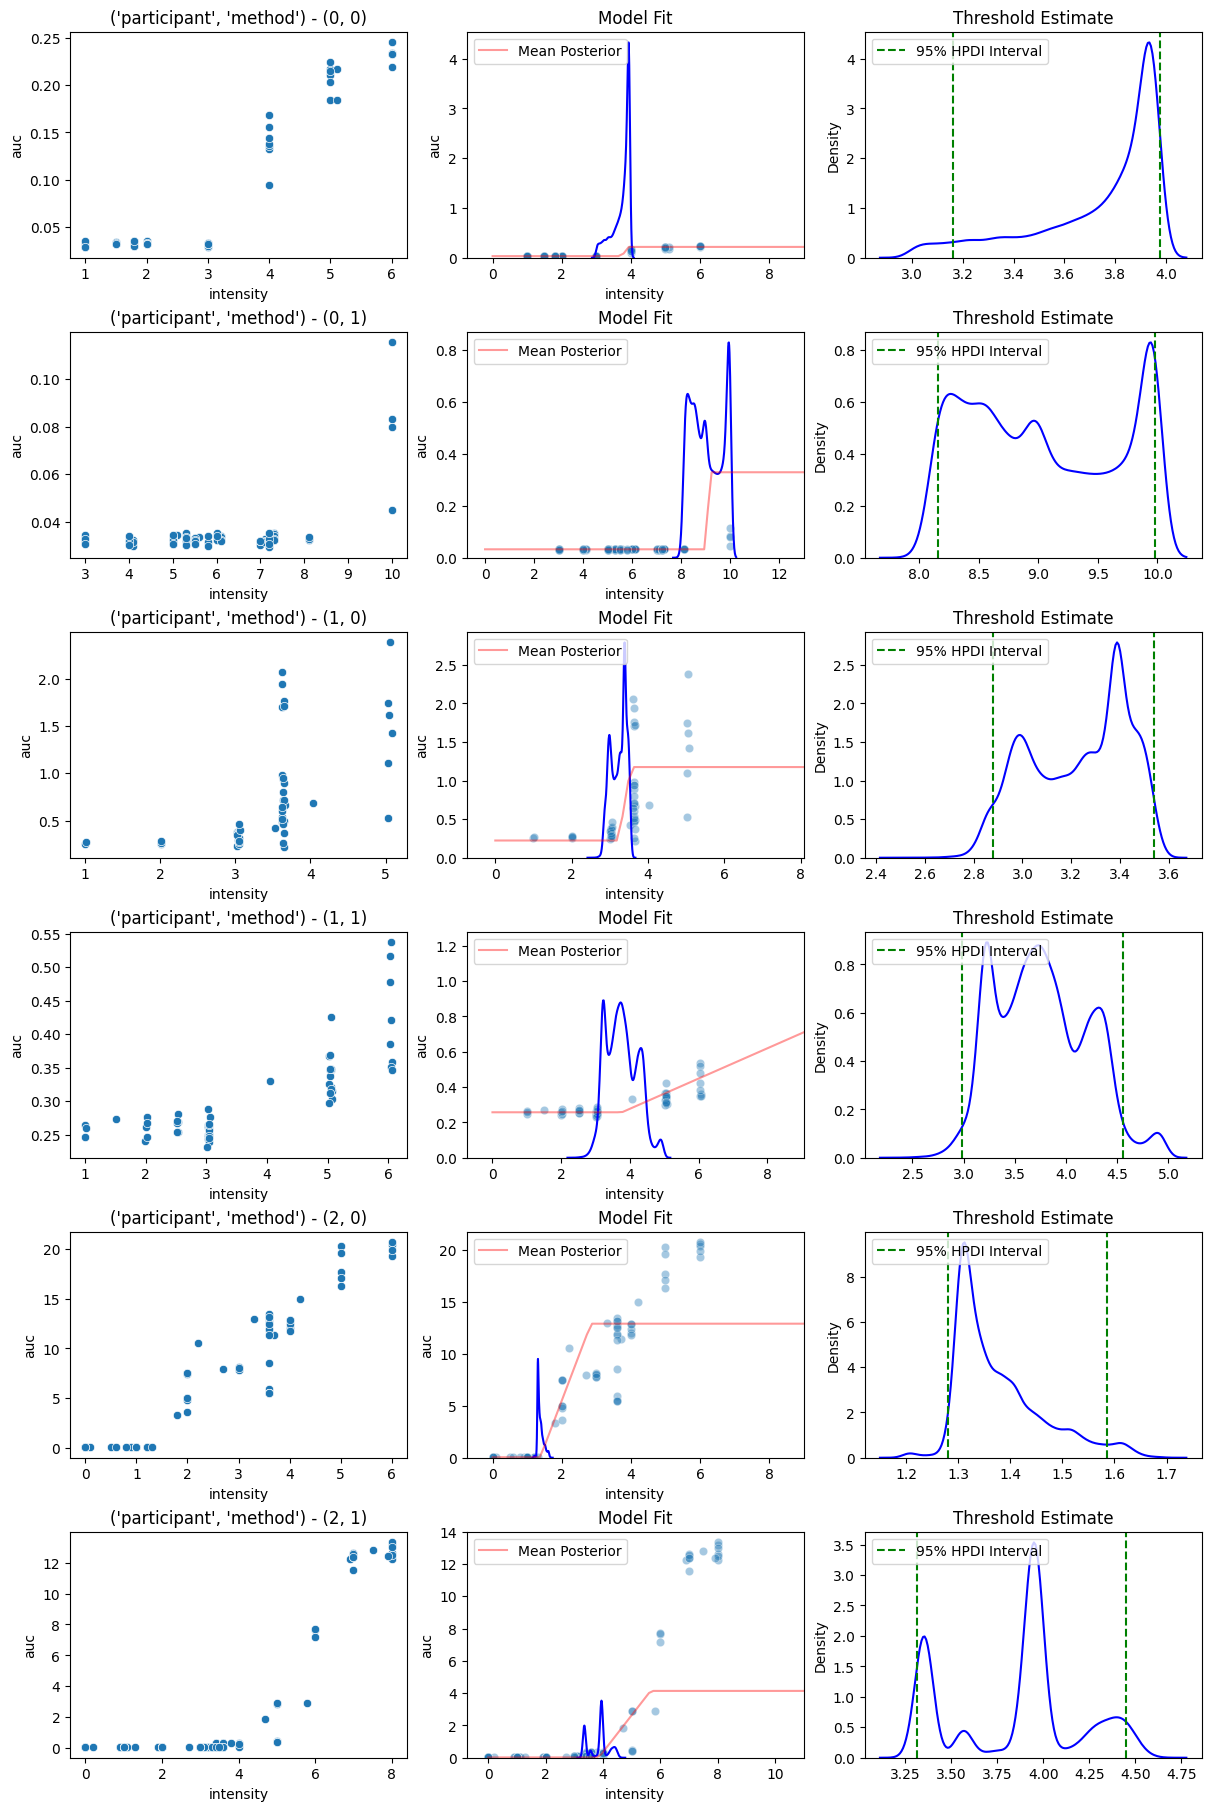

In [ ]:
model.plot(df=df, posterior_samples=posterior_samples);